## Сегментация опухолей мозга с помощью UNet

<img src="https://i.imgur.com/Q8oI4M6.png" 
     align="right" 
     width="300"
     style="padding: 20px;" />

Цель домашней работы - обучить [UNet](https://arxiv.org/abs/1505.04597) для сегментации опухолей головного мозга



### Загрузка данных
Данные представлены в виде питоновского словаря, где пары изображение-маска сохранены как .h5 файл, с ключами `image` и `mask`.

Датасет доступен по [ссылке](https://disk.yandex.ru/d/D_x_9woD55P8_g)

In [9]:
import numpy as np
import os
import h5py

# Directory containing .h5 files
path_to_data = 'datasets/'  # Change it accordingly 
directory = f'{path_to_data}BraTS2020_training_data/content/data'

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.755863264388587
Array min val: -0.5070322108800785

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


## О данных
В нашема датасете снимки МРТ головного мозга вместе с маской, показывающий на абнормальные участки тканей головного мозга. У каждого изображения 4 канала

#### Каналы:
1) **T1-weighted (T1)**: Канал, хранящий в себе изображение структуры тканей головного мозга в высоком разрешении. Хорошо для визуализации структуры мозга, но не так чувствителен к тканям опухолей, как другие типы каналов.

2) **T1-weighted post contrast (T1c or T1Gd)**: После инъекции котрастного агента (обычно gadolinium), T1-weighted изображения берутся вновь. Контрастный агент улучшает видимость областей с высокой степенью васкуляторности (активности сосудов), что типично для тканей опухолей, таким образом является наиболее оптимальным для визуализации областей со злокачественными опухолями.

3) **T2-weighted (T2)**: T2 изображения обладают вылеколепной контрастностью жидкостных участков головного мозга и чувствительны к эдемам (отечностям), которые часто окружают опухоли (tumors). Помогает визуализировать как опухоли, так и ткани вокруг них.

4) **Fluid Attenuated Inversion Recovery (FLAIR)**: Эта маска подавляет жидкостный сигнал, упрощая доступность перитуморального отека для визуализации, а так же помогает лучше различать отек от спиномозговой жидкости. 


В масках три канала:

#### Mask channels
1) **Necrotic and Non-Enhancing Tumour Core (NCR/NET)**: Маска для некротичных (мертвых) участков тканей опухоли, не подсвечивается контрастным агентом.

2) **Edema (ED)**: Эта маска подсвечивает эдему - припухлость тканей вокруг опухоли.

3) **Enhancing Tumour (ET)**: Показывает наиболее агрессивный регион опухоли.

### Viewing Sample Images
Воспользуемся матплотлибом для визуализации изобрадения и масок

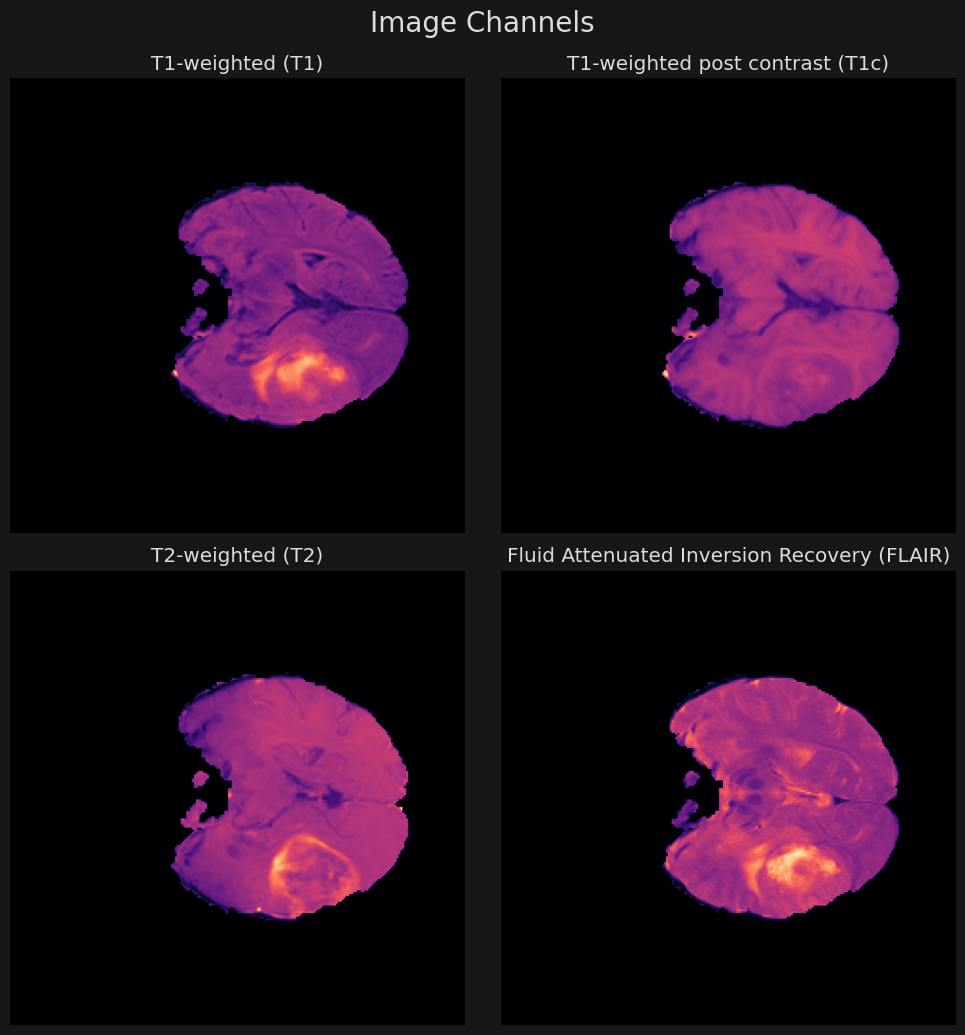

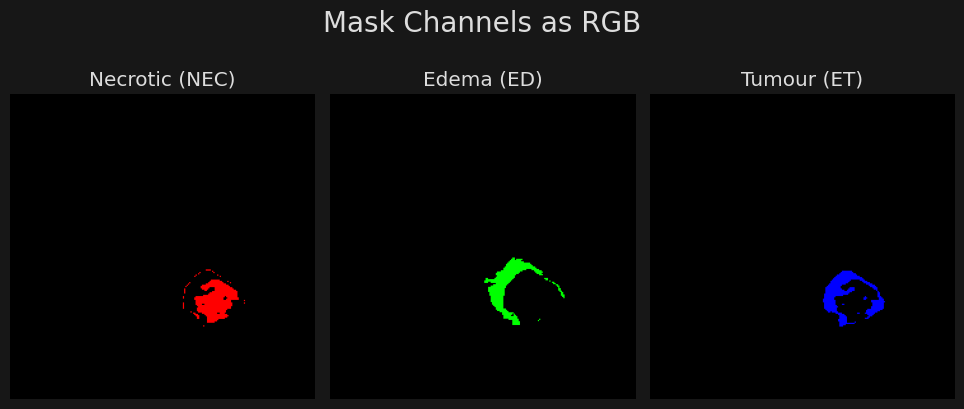

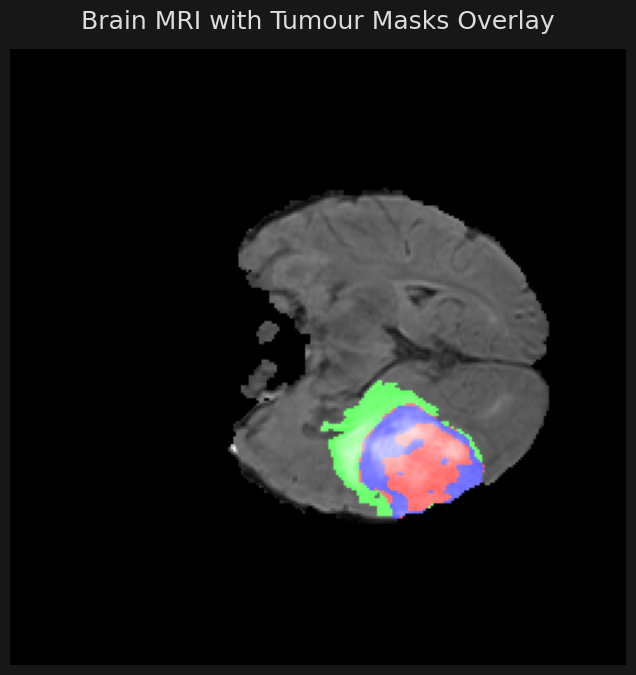

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_file_path = os.path.join(directory, h5_files[25071])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

### Создаем Dataset и DataLoader
Наш датасет относительно большой - ~8GB, поэтому возпользуемся dataloader для загрузки пар данных батчами. Посколько данные формат данных нестандартный, нам нужно написать свой собственный Dataset object и DataLoader. 

Изображения сохранены в формате `float64` с интенсивностью пикселя от ~-0.5 до ~230 и `height`, `width`, `channels` последовательностью каналов. Маски сохраннены в `uint8` и пиксели там представлены 0 и 1. 

Наш Dataset должен загрузить изображение, зарешейпить его в  `channels`, `height`, `width`, поправить значения пикселей чтобы минимум был в 0 на каждом изображении, затем каждый канал, чтобы максимум был 1, затем сконвертировать в  `torch.float32` tensor.

### 2 points

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            # (Height, Width, Channel) -> (Channel, Height, Width,)
            image = image.transpose(2, 0, 1)
            mask = mask.transpose(2, 0, 1) 
            
            # Adjusting pixel values for each channel in the image so they are between 0 and 1
            for i in range(image.shape[0]):    # Iterate over channels
                # image[i] = [x / torch.max(image[i]) for x in image[i]]
                image[i] = [x / 240 for x in image[i]]
            
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    assert images.shape == torch.Size([5, 4, 240, 240])
    assert masks.shape == torch.Size([5, 3, 240, 240])
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


## The UNet Architecture

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" 
     align="right" 
     width="500"
     style="padding: 20px;" />
     
[UNet](https://arxiv.org/abs/1505.04597) is a deep learning neural network architecture originally designed for image segmentation tasks, but has since found use in GANs and latent diffusion models. Similar to autoencoders, the UNet structures include an encoder for compressing the input into a lower dimensional representation and a decoder for reconstructing the output from this compressed form. However, UNet distinguishes itself from autoencoders with several features:


Подсказка: skip_connection может быть реазлизована как с помощью torch.cat, так и torch.add

### 4 points

Мы с вами писали UNet на семинаре, здесь нужно сделать то же самое - можно как перенсти архитектуру оттуда, либо дополнить скелетный код, который дан ниже. Можно и полностью переписать весь код здесь, сохранив лишь его верхнеуровневую структуру - класс для энкодера и декодера блоков, класс для модели.

Глубину можно менять по своему вкусу, но рекомендую не менее 3х слоев в глубину.

In [12]:
from torch import nn


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            activation,
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            activation
        )
    def forward(self, x):
        x = self.encoder_block(x)
        return x
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            activation,
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            activation
        )
    def forward(self, x):
        x = self.decoder_block(x)
        return x 

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()
        
        # Up and downsampling methods
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.upsample_4 = nn.ConvTranspose2d(n_filters * 8, n_filters * 4, kernel_size=2, stride=2)
        self.upsample_3 = nn.ConvTranspose2d(n_filters * 4, n_filters * 2, kernel_size=2, stride=2)
        self.upsample_2 = nn.ConvTranspose2d(n_filters * 2, n_filters * 2, kernel_size=2, stride=2)
        self.upsample_1 = nn.ConvTranspose2d(n_filters * 2, n_filters * 1, kernel_size=2, stride=2)
        
        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels,    n_filters * 1)
        self.enc_block_2 = EncoderBlock(n_filters * 1,  n_filters * 2)
        self.enc_block_3 = EncoderBlock(n_filters * 2,  n_filters * 2)
        self.enc_block_4 = EncoderBlock(n_filters * 2,  n_filters * 4)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(
                in_channels=n_filters * 4,
                out_channels=n_filters * 8,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(num_features=n_filters * 8),
            activation, 
            nn.Conv2d(
                in_channels=n_filters * 8,
                out_channels=n_filters * 8,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(num_features=n_filters * 8),
            activation
        )
        
        # Decoder
        self.dec_block_4 =  DecoderBlock(n_filters * 8, n_filters * 4)
        self.dec_block_3 =  DecoderBlock(n_filters * 4, n_filters * 2)
        self.dec_block_2 =  DecoderBlock(n_filters * 4, n_filters * 2)
        self.dec_block_1 =  DecoderBlock(n_filters * 2, n_filters * 1)
        
        # Output projection
        self.output = nn.Conv2d(n_filters * 1,  out_channels, kernel_size=(1,1), stride=1, padding=0)
        
    def forward(self, x):
        # x.shape = (5, 4, 240, 240)
        
        # Encoder
        enc_1_out = self.enc_block_1(x)
        x = self.downsample(enc_1_out)
        
        enc_2_out = self.enc_block_2(x)
        x = self.downsample(enc_2_out)
        
        enc_3_out = self.enc_block_3(x)
        x = self.downsample(enc_3_out)
        
        enc_4_out = self.enc_block_4(x)
        x = self.downsample(enc_4_out)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder
        x = self.upsample_4(x)
        x = torch.cat((x, enc_4_out), dim=1)    # skip_connection 4
        x = self.dec_block_4(x)

        x = self.upsample_3(x)
        x = torch.cat((x, enc_3_out), dim=1)    # skip_connection 3
        x = self.dec_block_3(x)

        x = self.upsample_2(x)
        x = torch.cat((x, enc_2_out), dim=1)    # skip_connection 2
        x = self.dec_block_2(x)
       
        x = self.upsample_1(x)
        x = torch.cat((x, enc_1_out), dim=1)    # skip_connection 1
        x = self.dec_block_1(x)
        
        x = self.output(x)
        
        return x.squeeze()
    
# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)

### Training Loop


### 4 points

In [13]:
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm

def train_model(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    val_dataloader: DataLoader, 
    verbose=True
):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    n_epochs = 10 
    learning_rate = 1e-3
    batches_per_epoch = 5
    lr_lambda = 0.9

    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer,lr_lambda=lambda epoch: lr_lambda)
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in tqdm(range(1, n_epochs + 1)):
        current_lr = scheduler.get_last_lr()

        # Training step
        model.train()
        
        train_epoch_loss = 0
        
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: 
                print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            
            train_inputs = train_inputs.to(device)
            
            train_targets = train_targets.to(device)
            
            optimizer.zero_grad()
            
            train_preds = model(train_inputs)
            
            train_batch_loss = loss_fn(train_preds, train_targets)
            
            train_epoch_loss += train_batch_loss.item()
            
            train_batch_loss.backward()
            
            optimizer.step()

        train_epoch_losses.append(train_epoch_loss / batches_per_epoch)
         
        # Validation step
        model.eval()
        val_epoch_loss = 0
        
        for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
            if verbose: 
                print(f"\rValid batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/val_batch_idx:.6f}", end='')
        
            val_inputs = val_inputs.to(device)
            
            val_targets = val_targets.to(device)
            
            val_preds = model(val_inputs)
            
            val_batch_loss = loss_fn(val_preds, val_targets)
            
            val_epoch_loss += val_batch_loss.item()
        
        val_epoch_losses.append(val_epoch_loss / batches_per_epoch)
        
        scheduler.step()

        if verbose: 
            print(f"\rEpoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {float(current_lr[0]):.6f}\n")
            
            
    save_model(model=model, path=f'model_weights_{epoch}_iter.pth')
    print("Training complete.")
    return train_epoch_losses, val_epoch_losses

In [14]:
# YOU CAN HAVE A DICT WITH TRAING PARAMS AS EXPERIMENT CONFIG

# Create UNet model and count params
model = UNet()
count_parameters(model)   # I had 5,496,451 params

# Create dataloaders

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, verbose=True)

Total Parameters: 2,128,003

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Valid batch: 1144/5, Avg batch loss: 0.0061929

 10%|█         | 1/10 [08:28<1:16:19, 508.88s/it]

Epoch: 1, Train loss: 95.630330, Val loss: 7.092934, lr 0.001000

Valid batch: 1139/5, Avg batch loss: 0.0063819

 20%|██        | 2/10 [17:00<1:08:02, 510.29s/it]

Epoch: 2, Train loss: 62.795822, Val loss: 7.312447, lr 0.000900

Valid batch: 1140/5, Avg batch loss: 0.0051917

 30%|███       | 3/10 [25:35<59:47, 512.43s/it]  

Epoch: 3, Train loss: 52.583943, Val loss: 5.947763, lr 0.000810

Valid batch: 1140/5, Avg batch loss: 0.0045366

 40%|████      | 4/10 [34:05<51:10, 511.80s/it]

Epoch: 4, Train loss: 46.710707, Val loss: 5.199325, lr 0.000729

Valid batch: 1140/5, Avg batch loss: 0.0039692

 50%|█████     | 5/10 [42:41<42:45, 513.07s/it]

Epoch: 5, Train loss: 42.854381, Val loss: 4.543714, lr 0.000656

Valid batch: 1143/5, Avg batch loss: 0.0041517

 60%|██████    | 6/10 [51:21<34:22, 515.60s/it]

Epoch: 6, Train loss: 39.828181, Val loss: 4.751617, lr 0.000590

Valid batch: 1143/5, Avg batch loss: 0.0041051

 70%|███████   | 7/10 [1:00:14<26:03, 521.20s/it]

Epoch: 7, Train loss: 37.381579, Val loss: 4.700680, lr 0.000531

Valid batch: 1144/5, Avg batch loss: 0.0034054

 80%|████████  | 8/10 [1:14:24<20:51, 626.00s/it]

Epoch: 8, Train loss: 35.039997, Val loss: 3.898083, lr 0.000478

Valid batch: 1142/5, Avg batch loss: 0.0032912

 90%|█████████ | 9/10 [1:28:35<11:36, 696.29s/it]

Epoch: 9, Train loss: 33.178783, Val loss: 3.763659, lr 0.000430

Valid batch: 1142/5, Avg batch loss: 0.0032623

100%|██████████| 10/10 [1:39:50<00:00, 599.07s/it]

Epoch: 10, Train loss: 31.531700, Val loss: 3.730648, lr 0.000387

Training complete.


In [43]:
input = torch.randn(3, 1, 3)
out = nn.functional.interpolate(input, scale_factor=2)

print(out)
print(f'input shape = {input.shape}')
print(f'out shape = {out.shape}')

tensor([[[-0.4342, -0.4342,  0.7534,  0.7534,  2.4908,  2.4908]],

        [[ 0.6829,  0.6829, -0.3443, -0.3443,  0.9745,  0.9745]],

        [[ 1.2987,  1.2987, -1.0178, -1.0178,  0.0889,  0.0889]]])
input shape = torch.Size([3, 1, 3])
out shape = torch.Size([3, 1, 6])


### Смотрим на результат
Здесь ничего менять не надо

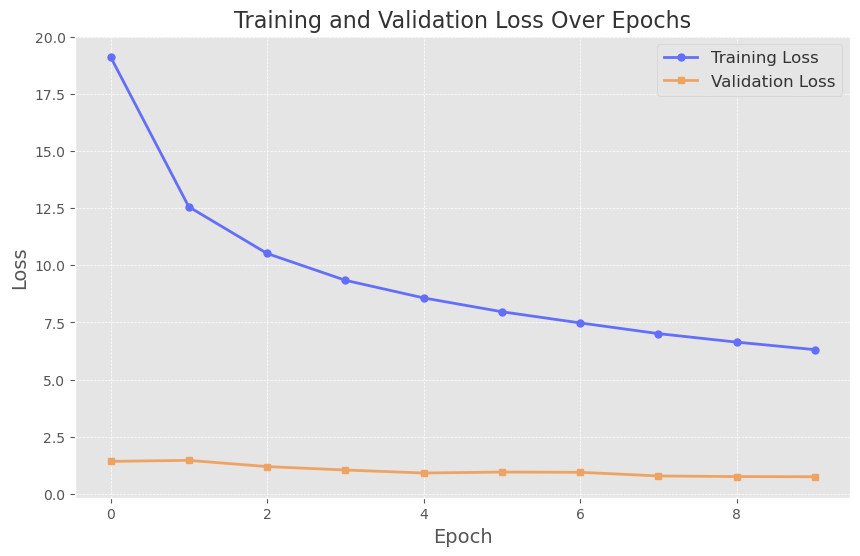

In [15]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot(train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot(val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    # axis.set_ylim(0, 1)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

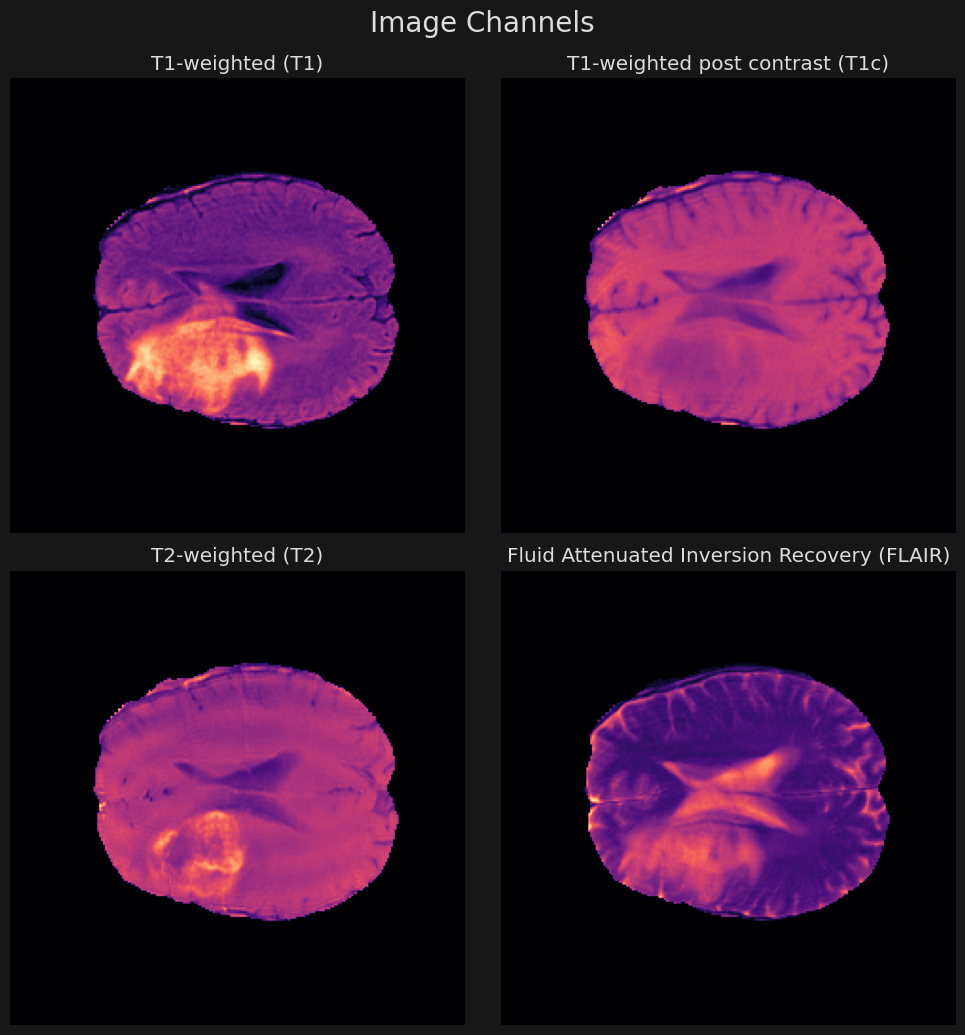

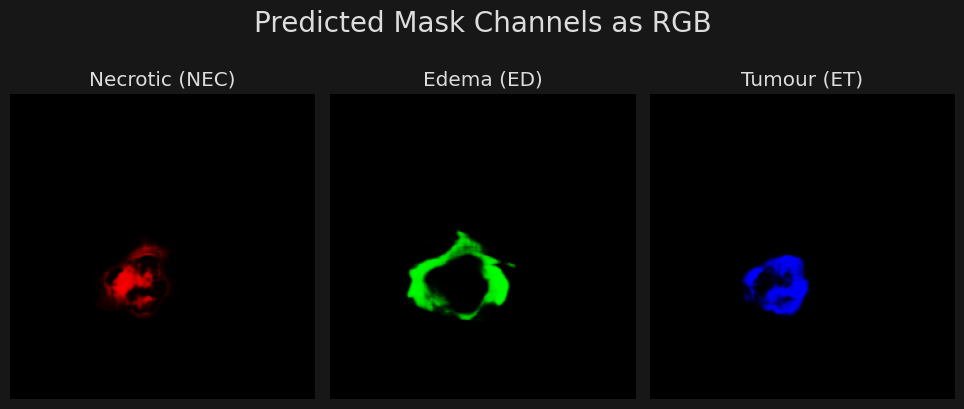

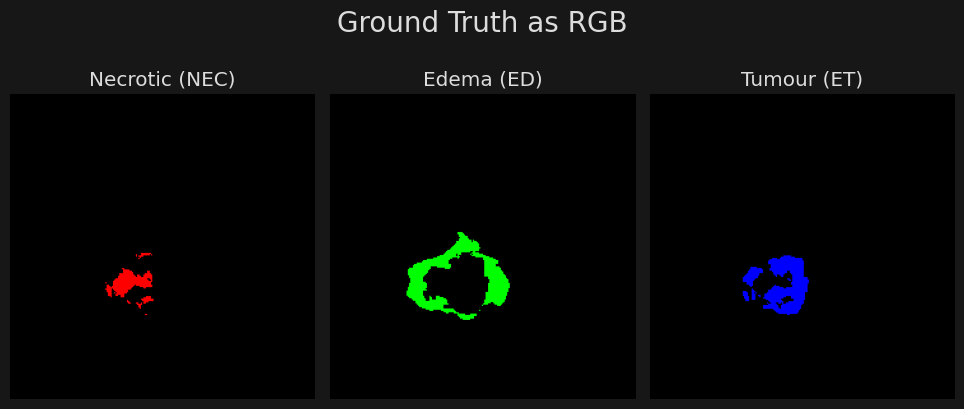

In [16]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze()
    mask_pred = test_pred.detach().cpu().numpy().squeeze()
    mask_target = test_target.detach().cpu().numpy().squeeze()

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)